# Training a DecisionTree algorithm on Real (CBS) data

Now we have learned about the Decision Tree algorithm, it is time to apply it to a real dataset. In this notebook, you will use a CBS dataset with statistics about municipalities and try to predict the degree of urbanization by using the features provided. As always we start by reading the dataset. 

## Read reference data: description of columns in data

The CBS dataset comes with an extra file describing the columns in the dataset. Let's read this file first.

In [ ]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.environ['DATA_DIRECTORY'] = '/content'
else:
    os.environ['DATA_DIRECTORY'] = '../../data'

data_directory = os.getenv('DATA_DIRECTORY')

In [ ]:
%%bash
if [ ! -f "$DATA_DIRECTORY/course-data.zip" ]; then
    wget "https://gitlab.com/api/v4/projects/52375047/jobs/artifacts/master/raw/data/course-data.zip?job=build_data_zip" -O "$DATA_DIRECTORY/course-data.zip"
    unzip "$DATA_DIRECTORY/course-data.zip" -d "$DATA_DIRECTORY"
fi

In [ ]:
import pandas as pd
 
kwb_description = pd.read_csv(os.path.join(data_directory, "kwb-2018-toelichting.csv"), delimiter=';', names=["column_name", "description", "comments"], index_col=0)
kwb_description.drop(columns=["comments"], inplace=True)
kwb_description.head()  


description
column_name                 
gwb_code_10      gwb code 10
gwb_code_8        gwb code 8
regio        Regioaanduiding
gm_naam         Gemeentenaam
recs             Soort regio

We can see that for every column in the dataset, there is a description of the column. This will help us understand the dataset better.
So if for example we want to know what the column `a_hh` means, we can look it up in this file using the following code:

In [3]:
kwb_description.loc['a_hh']

description    Huishoudens totaal
Name: a_hh, dtype: object

After reading the metadata, we can read the dataset itself. The dataset is stored in a CSV file, so we can use the `read_csv` function from the `pandas` library to read the dataset. We will also print the first few rows of the dataset to get an idea of what the dataset looks like.

In [ ]:
kwb_data = pd.read_csv(os.path.join(data_directory, "kwb-2018.csv"), delimiter=';', encoding='latin1')
kwb_data.head()

gwb_code_10  gwb_code_8               regio     gm_naam      recs  \
0        NL00           0           Nederland   Nederland      Land   
1      GM0003           3          Appingedam  Appingedam  Gemeente   
2    WK000300         300             Wijk 00  Appingedam      Wijk   
3  BU00030000       30000  Appingedam-Centrum  Appingedam     Buurt   
4  BU00030001       30001     Appingedam-West  Appingedam     Buurt   

     gwb_code ind_wbi     a_inw    a_man  a_vrouw  ...  a_bst_b  a_bst_nb  \
0        NL00       .  17181084  8527041  8654043  ...  6649495   1723750   
1      GM0003       .     11801     5751     6050  ...     4650       790   
2    WK000300       1     11800     5750     6050  ...     4645       790   
3  BU00030000       1      2355     1120     1235  ...      925       150   
4  BU00030001       1      3030     1505     1525  ...     1305       240   

   g_pau_hh  g_pau_km   a_m2w  a_opp_ha  a_lan_ha  a_wat_ha  ste_mvs  ste_oad  
0       1,1       249  661640   4154338   3367109    787228        2     1978  
1         1       229     550      2458      2378        80        3     1051  
2         1       229     550      2458      2378        80        3     1051  
3       0,8      1275      95        90        84         5        3     1195  
4       1,2       977     155       163       158         5        4      896  

[5 rows x 56 columns]

## Selecting the data we want to use

The dataset contains several types of regions, but we are only interested in the municipalities. We first have to find the rows that correspond to municipalities. Let's look at the metadata to find the column containing the region type.

In [5]:
kwb_description

description
column_name                            
gwb_code_10                 gwb code 10
gwb_code_8                   gwb code 8
regio                   Regioaanduiding
gm_naam                    Gemeentenaam
recs                        Soort regio
...                                 ...
a_wat_ha              Oppervlakte water
pst_mvp      Meest voorkomende postcode
pst_dekp             Dekkingspercentage
ste_mvs          Mate van stedelijkheid
ste_oad      Omgevingsadressendichtheid

[109 rows x 1 columns]

We can see here that the `recs` column contains the region type:

In [6]:
kwb_description.loc['recs']

description    Soort regio
Name: recs, dtype: object

To see what values the `recs` column can have, we can use the `unique` function from the `pandas` library. This function returns all unique values in a column.

In [7]:
kwb_data['recs'].unique()

array(['Land', 'Gemeente', 'Wijk', 'Buurt'], dtype=object)

We can filter the dataset to only include the municipalities by selecting the rows where the `recs` column is equal to `Gemeente`. 

In [8]:
data_for_selected_region_type = kwb_data[kwb_data.recs == 'Gemeente']
data_for_selected_region_type.head()

gwb_code_10  gwb_code_8       regio     gm_naam      recs gwb_code ind_wbi  \
1       GM0003           3  Appingedam  Appingedam  Gemeente   GM0003       .   
9       GM0005           5       Bedum       Bedum  Gemeente   GM0005       .   
19      GM0009           9    Ten Boer    Ten Boer  Gemeente   GM0009       .   
34      GM0010          10    Delfzijl    Delfzijl  Gemeente   GM0010       .   
64      GM0014          14   Groningen   Groningen  Gemeente   GM0014       .   

     a_inw   a_man  a_vrouw  ...  a_bst_b  a_bst_nb  g_pau_hh  g_pau_km  \
1    11801    5751     6050  ...     4650       790         1       229   
9    10475    5235     5240  ...     4045       965       1,1       112   
19    7292    3616     3676  ...     3025       710       1,3        82   
34   24864   12475    12389  ...    10220      2280       1,1        94   
64  202810  101299   101511  ...    53560     19295       0,6       768   

    a_m2w  a_opp_ha  a_lan_ha  a_wat_ha  ste_mvs  ste_oad  
1     550      2458      2378        80        3     1051  
9     515      4496      4454        41        4      685  
19    445      4573      4531        42        5      372  
34   1285     22750     13307      9443        4      677  
64   5255     10150      9492       658        1     3456  

[5 rows x 56 columns]

Finally, we can also check how many municipalities are in the dataset.

In [9]:
len(data_for_selected_region_type)

380

The filtered dataset contains 380 municipalities. The data is from 2018, and indeed that number is correct. 

## Get the Labels

Next, it is time to get our features and target variable. The target variable is the degree of urbanization, which is stored in the `ste_mvs` column. The features can be the other columns in the dataset. We can retrieve the target variable by using the following code:

In [10]:
y_true = data_for_selected_region_type[['ste_mvs']]

Now the variable `y_true` contains the target variable. In this case, the target variable is the degree of urbanization. CBS classifies the degree of urbanization into five classes. Based on the environmental address density, each neighborhood, district, or municipality has been assigned an urbanization class. The following classification has been used:

1: very strongly urbanized >= 2,500 addresses per km²

2: strongly urbanized 1,500 - 2,500 addresses per km²

3: moderately urbanized 1,000 - 1,500 addresses per km²

4: weakly urbanized 500 - 1,000 addresses per km²

5: non-urbanized < 500 addresses per km²

Let's see how many municipalities are in each class.

In [18]:
target_name = ['ste_mvs']
target_categories = ['very strongly urbanized', 'strongly urbanized', 'moderately urbanized', 'weakly urbanized', 'non-urbanized']
y_true[target_name].value_counts().sort_index()

ste_mvs
1           19
2           74
3           78
4          135
5           74
Name: count, dtype: int64

Most municipalities are classified as weakly urbanized.

## Selecting some features

The dataset contains a lot of characteristics per municipality. Not all of these characteristics are useful for predicting the degree of urbanization. We can select a subset of the features that we think are most relevant. For example, we can select the area of the municipality in hectares and the number of households as features:

In [12]:
feature_names = ['a_opp_ha','a_hh']
X = data_for_selected_region_type[feature_names]
X.head(5)

a_opp_ha    a_hh
1       2458    5540
9       4496    4391
19      4573    2980
34     22750   11617
64     10150  122541

## Split the Data into training and testing data

Now that we have our features and target variable, we can split the data into training and testing data. We will use 80% of the data for training and 20% for testing. We can use the `train_test_split` function from the `sklearn` library to split the data.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_true, random_state=0)

## Train the Model

Once we have split the data we can train the Decision Tree model. We can use the `DecisionTreeClassifier` class from the `sklearn` library to create a Decision Tree model. We can then use the `fit` method to train the model on the training data.

In [14]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 1)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

## Visualize the model

After training the model, we can visualize the Decision Tree. Decision Trees are easy to interpret and visualize. However, as you will see, the Decision Tree for this dataset is quite large and therefore may be more difficult to interpret. Still, the visualization is more intuitive than a visualization of the Multi-Layer Perceptron that we saw in previous notebooks.

In [ ]:
from sklearn.tree import export_graphviz
import graphviz


dot_data = export_graphviz(decision_tree, 
                            out_file=None,
                            feature_names=feature_names,
                            class_names=target_categories,
                            filled=True, rounded=True,
                            special_characters=True)

graph = graphviz.Source(dot_data)
graph

graph.render(os.path.join(data_directory, 'decision_tree'), view=True) # for printing to pdf

'../decision_tree.pdf'

## Evaluate the Model

To evaluate the model, we will use the `classification_report` function from the `sklearn.metrics` module. As we saw, this function calculates various metrics that are useful for evaluating the performance of a classification model. We evaluate the model on the test data.

In [19]:
from sklearn.metrics import classification_report

y_pred = decision_tree.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_categories))

                         precision    recall  f1-score   support

very strongly urbanized       1.00      0.33      0.50         3
     strongly urbanized       0.64      0.78      0.70        18
   moderately urbanized       0.26      0.29      0.28        17
       weakly urbanized       0.66      0.49      0.56        39
          non-urbanized       0.46      0.61      0.52        18

               accuracy                           0.53        95
              macro avg       0.60      0.50      0.51        95
           weighted avg       0.56      0.53      0.53        95



In this example, we see that there are more than two labels. As opposed to the Titanic dataset, we now have a multi-class classification problem. The classification report shows the precision, recall, and F1-score for each class. The support column shows the number of samples for each class. To know if the model is performing well, and outperforming a random guess, we can use the `DummyClassifier` class from the `sklearn` library (see the documentation [here](https://scikit-learn.org/dev/modules/generated/sklearn.dummy.DummyClassifier.html)). This class provides several strategies for making predictions. Here, we are using the `stratified` strategy; this strategy generates random predictions by respecting the training set's class distribution. By comparing the predictions of our Decision Tree model with the performance of the `DummyClassifier`, we can test whether the model has learned to predict anything.

In [20]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_categories))

                         precision    recall  f1-score   support

very strongly urbanized       0.00      0.00      0.00         3
     strongly urbanized       0.14      0.17      0.15        18
   moderately urbanized       0.13      0.18      0.15        17
       weakly urbanized       0.37      0.28      0.32        39
          non-urbanized       0.17      0.17      0.17        18

               accuracy                           0.21        95
              macro avg       0.16      0.16      0.16        95
           weighted avg       0.23      0.21      0.22        95



We see that our `DecisionTree` model outperforms the `DummyClassifier` model. The Decision Tree model has a higher precision, recall, and F1-score for all classes. This means that the Decision Tree model has learned to predict the degree of urbanization better than a random guess. However, we can see the model can still be improved. We leave it as an exercise for you to try to improve the model by selecting different features or tuning the hyperparameters of the Decision Tree model.

## Example: Creating Derived Features

One way to improve the model is to create new features from the existing features. For example, we can calculate the population density by dividing the number of inhabitants by the area of the municipality. We can then use this new feature as input for the Decision Tree model. Let's see how we can do this:

In [29]:
# a_opp_ha is totale oppervlakte in hele hectaren.
# een km2 is 100 hectaren
# data: inwoners, huishoudens
# 1: zeer sterk stedelijk >= 2 500 adressen per km²
# 2: sterk stedelijk 1 500 - 2 500 adressen per km²
# 3: matig stedelijk 1 000 - 1 500 adressen per km²
# 4: weinig stedelijk 500 - 1 000 adressen per km²
# 5: niet stedelijk < 500 adressen per km²

data_for_selected_region_type['a_hh_p_km2'] = data_for_selected_region_type['a_hh'] / (data_for_selected_region_type['a_opp_ha']/100)
data_for_selected_region_type[['a_hh_p_km2','a_hh','a_opp_ha']].head(5)

/var/folders/5s/1qqrrxd175v_vzyy65mh_y0m0000gn/T/ipykernel_27891/3336679801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_selected_region_type['a_hh_p_km2'] = data_for_selected_region_type['a_hh'] / (data_for_selected_region_type['a_opp_ha']/100)


a_hh_p_km2    a_hh  a_opp_ha
1    225.386493    5540      2458
9     97.664591    4391      4496
19    65.165099    2980      4573
34    51.063736   11617     22750
64  1207.300493  122541     10150

In [34]:
from sklearn.model_selection import train_test_split

feature_names = ['a_hh_p_km2']
X = data_for_selected_region_type[feature_names]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, random_state=0)
X.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((380, 1), (285, 1), (95, 1), (285, 1), (95, 1))

In [36]:
# all in one cell
feature_names = ['a_hh_p_km2']

decision_tree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 50)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_categories))

                         precision    recall  f1-score   support

very strongly urbanized       0.00      0.00      0.00         3
     strongly urbanized       0.67      0.56      0.61        18
   moderately urbanized       0.43      0.71      0.53        17
       weakly urbanized       0.74      0.74      0.74        39
          non-urbanized       0.77      0.56      0.65        18

               accuracy                           0.64        95
              macro avg       0.52      0.51      0.51        95
           weighted avg       0.65      0.64      0.64        95



/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

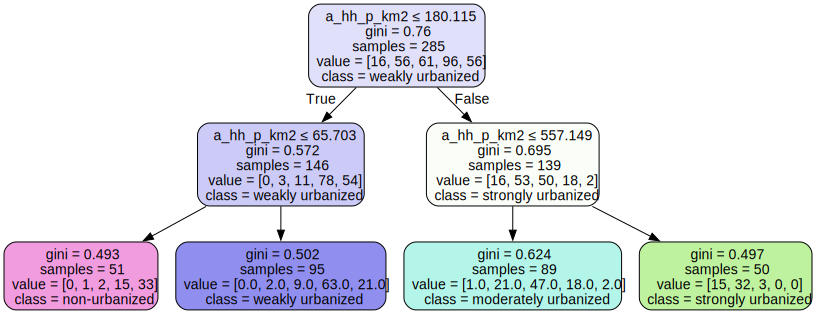

In [38]:
dot_data = export_graphviz(decision_tree, out_file=None,
                      feature_names=feature_names,
                      class_names=target_categories,
                      filled=True, rounded=True,
                      special_characters=True)

graph = graphviz.Source(dot_data)
graph

Now try to add more features to the model and see if you can improve the performance of the model.

In [ ]:
# Add your code and new cells here